# Using a CNN for Pet Image Segmentation and Binary Classification with Oxford IIIT Pet Dataset

What is segmentation?

- It is a way to partition an image into different sections. 

What is the goal here?

- The Oxford IIIT Pet Dataset comes with a pixel level foreground background segmentation. I want to predict this segmentation and get the outline of the animal. 

## Load the Dataset and Preprocess

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/4.0.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed and
    species. Additionally, head bounding boxes are provided for the training split,
    allowing using this dataset for simple object detection tasks. In the test
    split, the bounding boxes are empty.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir='/Users/kellylee/tensorflow_datasets/oxford_iiit_pet/4.0.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=773.68 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'head_bbox': BBoxFeature(shape=(4,), dtype=float32),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label'

2025-05-27 13:29:33.106636: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Image batch shape: torch.Size([8, 3, 128, 128]), Mask batch shape: torch.Size([8, 128, 128])


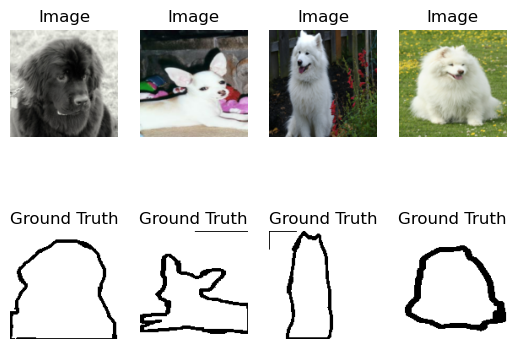

In [ ]:
import tensorflow_datasets as tfds
from torchvision import datasets, transforms
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

# loading dataset from tensorflow_datasets 
dataset, info = tfds.load('oxford_iiit_pet', split='train', with_info=True, as_supervised=False)
builder = tfds.builder('oxford_iiit_pet')
info = builder.info
print(info)

WIDTH = 128
HEIGHT = 128
SIZE = (WIDTH, HEIGHT)

# transform images
data_transform = transforms.Compose([
    transforms.Resize(size=SIZE),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# transform mask
mask_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(SIZE, interpolation=transforms.InterpolationMode.NEAREST),
])

# create custom pytorch dataset from tensorflow dataset
class PyTorchDataset(Dataset):
    def __init__(self, tfds_data):
        self.tfds_data = list(tfds_data)

    def __len__(self):
        return len(self.tfds_data)
    
    def __getitem__(self, idx):
        example = self.tfds_data[idx]
        image = example['image'].numpy()
        mask = example['segmentation_mask'].numpy()
        label = (example['species'].numpy())
        
        # convert numpy arrays to pil image for transformation
        image = transforms.functional.to_pil_image(image)
        mask = transforms.functional.to_pil_image(mask)

        image = data_transform(image)
        mask = mask_transform(mask)

        mask = (mask * 255).long()

        # convert class 3 (boundary) to 0 (background), else 1
        mask = torch.where(mask == 3, torch.zeros_like(mask), torch.ones_like(mask))

        return image, mask.squeeze(0), label
    
torch_data = PyTorchDataset(dataset)
dataloader = DataLoader(torch_data, batch_size=8, shuffle=True)

images, masks, labels = next(iter(dataloader))

print(f"Image batch shape: {images.shape}, Mask batch shape: {masks.shape}")

# show four images with the ground truth mask
for i in range(4):
    plt.subplot(2, 4, i+1)
    plt.imshow(images[i].permute(1, 2, 0))
    plt.axis('off')
    plt.title("Image")

    plt.subplot(2, 4, i+5)
    plt.imshow(masks[i], cmap='gray')
    plt.axis('off')
    plt.title("Ground Truth")

plt.show()

## Extract features and labels for SVM

In [ ]:

features = []
labels_svm = []

for index, (images, masks, labels) in enumerate(dataloader):
    # convert tensors to numpy arrays
    images = images.permute(0, 2, 3, 1).numpy()
    masks = masks.numpy()

    B, H, W, _ = images.shape

    for i in range(B):
        image = images[i]
        mask = masks[i]

        # get foreground and background pixels
        fg = np.argwhere(mask == 1)
        bg = np.argwhere(mask == 0)

        # sample at most 1500 pixels
        N = min(len(fg), len(bg), 1500)  

        # sample foreground and background pixels
        fg_sample = fg[np.random.choice(len(fg), N, replace=False)]
        bg_sample = bg[np.random.choice(len(bg), N, replace=False)]

        # mix pixels
        coords = np.vstack([fg_sample, bg_sample])
        np.random.shuffle(coords)

        for y, x in coords:
            # getting the color from pixel
            pixel = image[y, x]

            # creating feature vector of RGB and XY position that is normalized
            feature = [pixel[0], pixel[1], pixel[2], x / W, y / H]
            features.append(feature)
            labels_svm.append(mask[y, x])

    # do 10 batches
    if index >= 10:
        break

features = np.array(features)
labels_svm = np.array(labels_svm)



## Train the SVM for segmentation

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

scaler = StandardScaler()

# fit and transform the data
X_scaled = scaler.fit_transform(features)

svm = SVC(kernel='rbf', C=1.0)

# train svm 
svm.fit(X_scaled, labels)




SVC()

## Mask Predictions with SVM

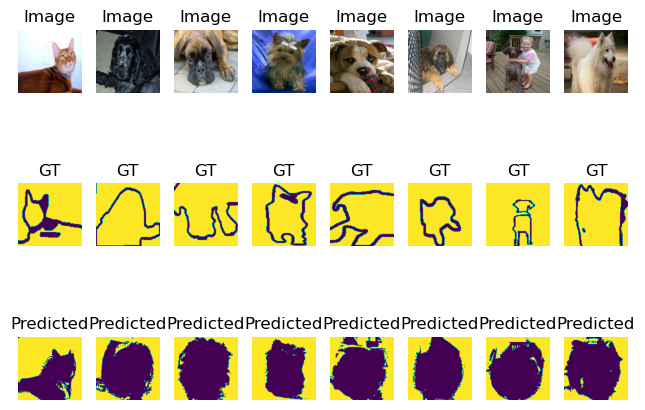

In [ ]:

# This code works to predict for one image:
###########################################

# def show_image(image, mask, pred):
#     plt.subplot(3, 1, 1)
#     plt.imshow(image)
#     plt.title("Image")
#     plt.axis('off')

#     plt.subplot(3, 1, 2)
#     plt.imshow(mask[0].numpy())
#     plt.title("Ground Truth")
#     plt.axis('off')

#     plt.subplot(3, 1, 3)
#     plt.imshow(pred)
#     plt.title("Predicted Mask")
#     plt.axis('off')


# test_images, test_masks = next(iter(dataloader))
# test_image = test_images[0].permute(1, 2, 0).numpy()
# H, W, _ = test_image.shape

# test_features = []

# for y in range(H):
#     for x in range(W):
#         pixel = test_image[y, x]
#         test_features.append([pixel[0], pixel[1], pixel[2], x / W, y / H])

# test_features = np.array(test_features)
# test_features_scaled = scaler.transform(test_features)

# pred = svm.predict(test_features_scaled)
# pred_mask = pred.reshape(H, W)

# show_image(test_image, test_masks, pred_mask)


# This code works to predict multiple images at once:
#####################################################

def predict_multiple(images, scaler, svm):
    preds = []

    for img in images:
        img_np = img.permute(1, 2, 0).numpy()
        
        H, W, _ = img_np.shape

        features = []

        for y in range(H):
            for x in range(W):
                pixel = img_np[y, x]
                features.append([pixel[0], pixel[1], pixel[2], x / W, y / H])

        features = np.array(features)
        features_scaled = scaler.transform(features)

        pred = svm.predict(features_scaled)
        pred_mask = pred.reshape(H, W)

        preds.append(pred_mask)
    
    return preds

def show_multiple_images(images, masks, preds):
    len_img = len(images)

    # iterate through and plot image, ground truth, and predicted mask
    for i in range(len_img):
        img = images[i].permute(1, 2, 0).numpy()
        mask = masks[i].numpy()
        pred = preds[i]

        plt.subplot(3, len_img, i + 1)
        plt.imshow(img)
        plt.title("Image")
        plt.axis('off')

        plt.subplot(3, len_img, len_img + i + 1)
        plt.imshow(mask)
        plt.title("GT")
        plt.axis('off')

        plt.subplot(3, len_img, 2 * len_img + i + 1)
        plt.imshow(pred)
        plt.title("Predicted")
        plt.axis('off')
    plt.tight_layout()
    plt.subplots_adjust(top=0.9, hspace=0.4)
    plt.show()


test_images, test_masks = next(iter(dataloader))
pred_masks = predict_multiple(test_images, scaler, svm)
show_multiple_images(test_images, test_masks, pred_masks)

While SVM seems to work for prediction of masks, I think we can do better with a CNN model. 

## Training and Evaluating CNN model for Pet Image Segmentation

Epoch 1 Loss: 0.3726


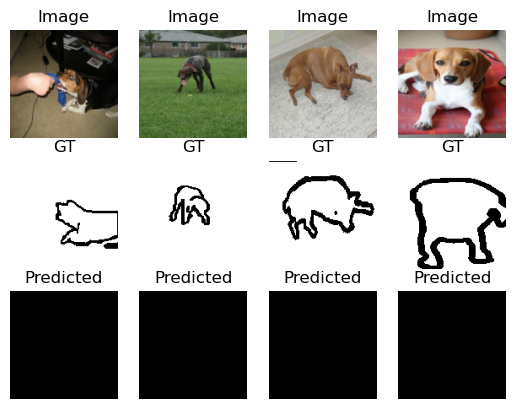

Epoch 2 Loss: 0.3485
Epoch 3 Loss: 0.3482
Epoch 4 Loss: 0.3454
Epoch 5 Loss: 0.3401
Epoch 6 Loss: 0.3363
Epoch 7 Loss: 0.3336
Epoch 8 Loss: 0.3294
Epoch 9 Loss: 0.3257
Epoch 10 Loss: 0.3217
Epoch 11 Loss: 0.3182


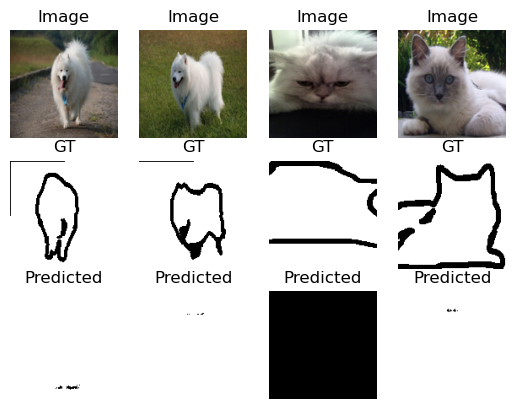

Epoch 12 Loss: 0.3155
Epoch 13 Loss: 0.3117
Epoch 14 Loss: 0.3096
Epoch 15 Loss: 0.3069
Epoch 16 Loss: 0.3035
Epoch 17 Loss: 0.3007
Epoch 18 Loss: 0.2984
Epoch 19 Loss: 0.2952
Epoch 20 Loss: 0.2920
Epoch 21 Loss: 0.2896


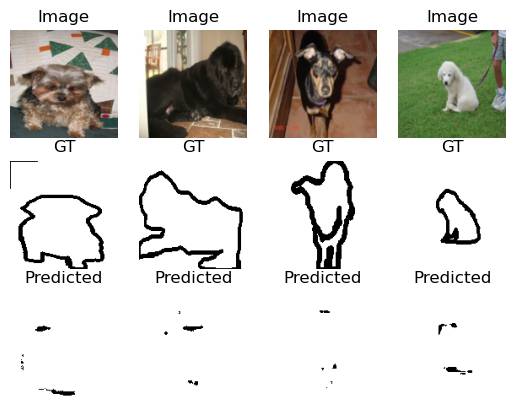

Epoch 22 Loss: 0.2857
Epoch 23 Loss: 0.2831
Epoch 24 Loss: 0.2797
Epoch 25 Loss: 0.2754
Epoch 26 Loss: 0.2725
Epoch 27 Loss: 0.2689
Epoch 28 Loss: 0.2654
Epoch 29 Loss: 0.2630
Epoch 30 Loss: 0.2583
Epoch 31 Loss: 0.2554


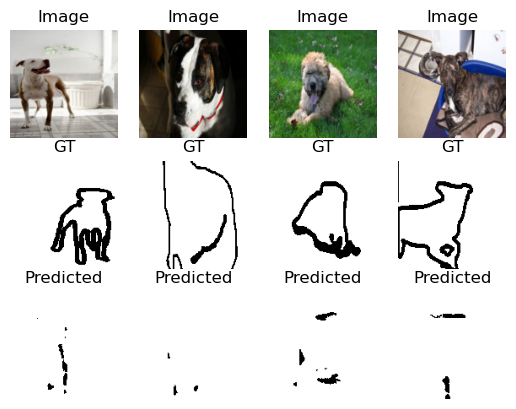

Epoch 32 Loss: 0.2515
Epoch 33 Loss: 0.2481
Epoch 34 Loss: 0.2439
Epoch 35 Loss: 0.2418
Epoch 36 Loss: 0.2393
Epoch 37 Loss: 0.2361
Epoch 38 Loss: 0.2338
Epoch 39 Loss: 0.2308
Epoch 40 Loss: 0.2290
Epoch 41 Loss: 0.2256


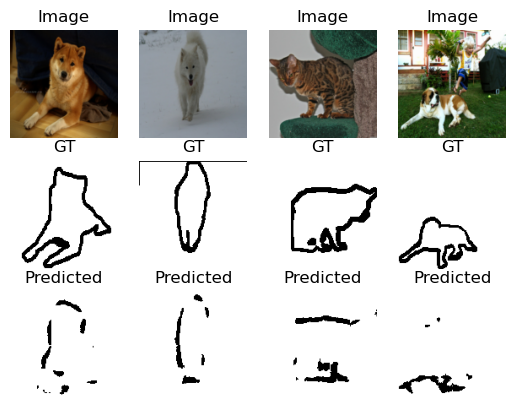

Epoch 42 Loss: 0.2226
Epoch 43 Loss: 0.2212
Epoch 44 Loss: 0.2190
Epoch 45 Loss: 0.2180
Epoch 46 Loss: 0.2152
Epoch 47 Loss: 0.2124
Epoch 48 Loss: 0.2114
Epoch 49 Loss: 0.2085
Epoch 50 Loss: 0.2084
Epoch 51 Loss: 0.2055


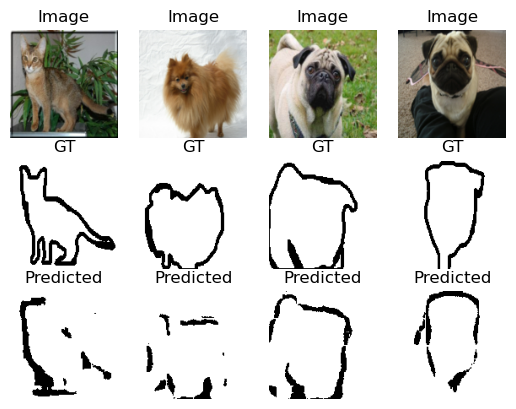

Epoch 52 Loss: 0.2037
Epoch 53 Loss: 0.2030
Epoch 54 Loss: 0.2013
Epoch 55 Loss: 0.1997
Epoch 56 Loss: 0.1982
Epoch 57 Loss: 0.1973
Epoch 58 Loss: 0.1955
Epoch 59 Loss: 0.1934
Epoch 60 Loss: 0.1931
Epoch 61 Loss: 0.1909


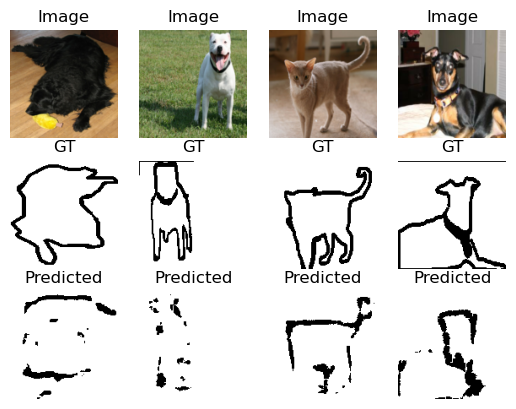

Epoch 62 Loss: 0.1905
Epoch 63 Loss: 0.1892
Epoch 64 Loss: 0.1892
Epoch 65 Loss: 0.1862
Epoch 66 Loss: 0.1849
Epoch 67 Loss: 0.1846
Epoch 68 Loss: 0.1841
Epoch 69 Loss: 0.1830
Epoch 70 Loss: 0.1822
Epoch 71 Loss: 0.1798


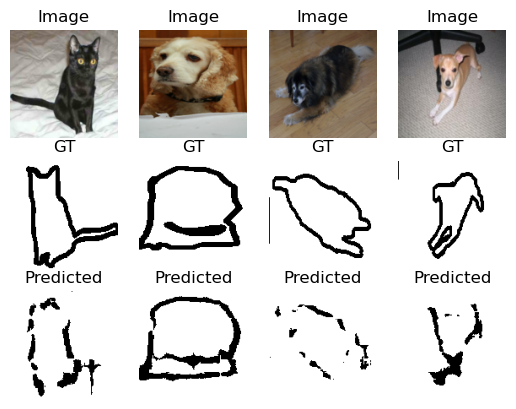

Epoch 72 Loss: 0.1808
Epoch 73 Loss: 0.1794
Epoch 74 Loss: 0.1780
Epoch 75 Loss: 0.1770
Epoch 76 Loss: 0.1771
Epoch 77 Loss: 0.1756
Epoch 78 Loss: 0.1757
Epoch 79 Loss: 0.1729
Epoch 80 Loss: 0.1730
Epoch 81 Loss: 0.1726


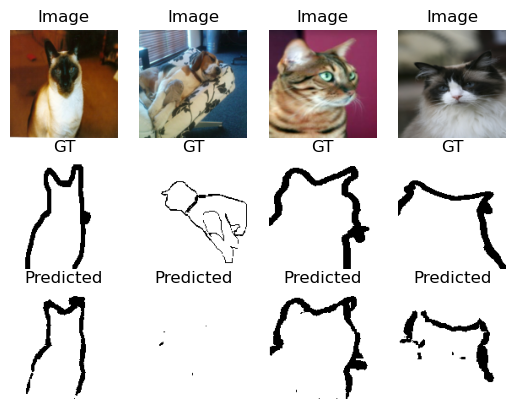

Epoch 82 Loss: 0.1710
Epoch 83 Loss: 0.1713
Epoch 84 Loss: 0.1713
Epoch 85 Loss: 0.1704
Epoch 86 Loss: 0.1694
Epoch 87 Loss: 0.1678
Epoch 88 Loss: 0.1674
Epoch 89 Loss: 0.1669
Epoch 90 Loss: 0.1664
Epoch 91 Loss: 0.1663


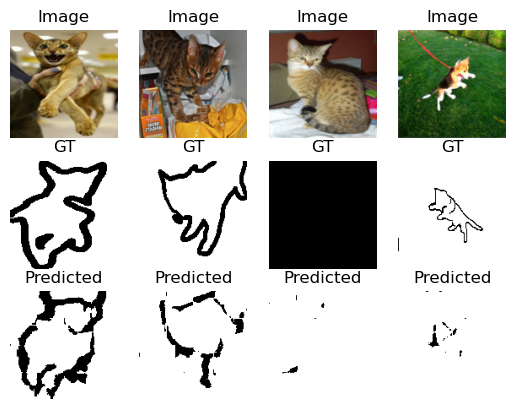

Epoch 92 Loss: 0.1654
Epoch 93 Loss: 0.1649
Epoch 94 Loss: 0.1639
Epoch 95 Loss: 0.1628
Epoch 96 Loss: 0.1633
Epoch 97 Loss: 0.1620
Epoch 98 Loss: 0.1616
Epoch 99 Loss: 0.1613
Epoch 100 Loss: 0.1612


In [ ]:
import torch.nn as nn
import torch.optim as optim

# custom CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # encoder
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        # decoder
        self.convt1 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.convt2 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.convt3 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.convt4 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.convt5 = nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1)
                                         

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        x = self.relu(self.conv4(x))
        x = self.pool(x)
        x = self.relu(self.conv5(x))
        x = self.pool(x)
        x = self.relu(self.convt1(x))
        x = self.relu(self.convt2(x))
        x = self.relu(self.convt3(x))
        x = self.relu(self.convt4(x))
        x = self.sigmoid(self.convt5(x))

        return x
    
# run 100 epochs or specified number of epochs to train model
def evaluate_model(model, optimizer, criterion, dataloader, device, num_epochs=100):
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for images, masks in dataloader:
            images = images.to(device)
            masks = (masks > 0).unsqueeze(1).float().to(device) 
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        model.eval()

        with torch.no_grad():
            # one batch at a time
            val_images, val_masks = next(iter(dataloader))
            val_images = val_images.to(device)
            val_masks = val_masks.to(device)
            outputs = model(val_images)
            preds = (outputs > 0.5).squeeze(1).cpu()
            val_images = val_images.cpu()
            val_masks = val_masks.cpu()

        
        print(f"Epoch {epoch+1} Loss: {total_loss/len(dataloader):.4f}")

        # every 10 epochs, visualize results
        if epoch % 10 == 0:
                
            for i in range(4):
                plt.subplot(3, 4, i + 1)
                plt.imshow(val_images[i].permute(1, 2, 0).cpu())
                plt.title("Image")
                plt.axis('off')

                plt.subplot(3, 4, i + 5)
                plt.imshow(val_masks[i], cmap='gray')
                plt.title("GT")
                plt.axis('off')

                plt.subplot(3, 4, i + 9)
                plt.imshow(preds[i], cmap='gray')
                plt.title("Predicted")
                plt.axis('off')
            plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

evaluate_model(model, optimizer, criterion, dataloader, device)

After 100 epochs, the CNN model converged well, reaching a loss of 0.1612. 

## Creating a custom CNN for both segmentation and classification

Let's see if we can create a new CNN that can be used for both segmentation and classification

In [ ]:
# new CNN model combining segmentation and classification 
class SegClassCNN(nn.Module):
    def __init__(self):
        super(SegClassCNN, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1), nn.Sigmoid()
        )

        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        features  = self.encoder(x)
        seg_output = self.decoder(features)
        class_output = self.classifier(self.pool(features))

        return seg_output, class_output
    

## Helper functions to evaluate model

In [ ]:
def plot_images(images, masks, preds, labels, pred_labels):
    names = ["cat", "dog"]
    num_images = len(images)
    plt.figure(figsize=(15, 6))

    for i in range(num_images):
        plt.subplot(3, num_images, i + 1)
        plt.imshow(images[i].permute(1, 2, 0).cpu())
        # show the true labels in comparison to the predicted labels
        plt.title(f"Image\nTrue Label: {names[int(labels[i])]}\nPredicted: {names[int(pred_labels[i] > 0.5)]}")
        plt.axis('off')

        plt.subplot(3, num_images, num_images + i + 1)
        plt.imshow(masks[i].cpu(), cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis("off")

        plt.subplot(3, num_images, 2 * num_images + i + 1)
        plt.imshow(preds[i].cpu(), cmap='gray')
        plt.title("Predicted Mask")
        plt.axis("off")
        plt.tight_layout()

    plt.show()        


def evaluate_model(model, optimizer, dataloader, device, num_epochs=100):
    seg_criterion = nn.BCELoss()
    class_criterion = nn.BCEWithLogitsLoss()

    for epoch in range(num_epochs):
        model.train()
        loss_seg = 0
        loss_class = 0
        total_seg_loss = 0
        total_class_loss = 0

        for images, masks, labels in dataloader:
            images = images.to(device)
            masks = (masks > 0).unsqueeze(1).float().to(device)
            labels = labels.float().unsqueeze(1).to(device)

            optimizer.zero_grad()
            pred_masks, pred_labels = model(images)

            # separate losses for segmentation and classification
            loss_seg = seg_criterion(pred_masks, masks)
            loss_class = class_criterion(pred_labels, labels)

            # weighted loss to focus more on the segmentation 
            loss = loss_seg + 0.3 * loss_class

            loss.backward()
            optimizer.step()
            total_seg_loss += loss_seg.item()
            total_class_loss += loss_class.item()

        model.eval()
        avg_seg_loss = total_seg_loss / len(dataloader)
        avg_class_loss = total_class_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{num_epochs} - Seg Loss: {avg_seg_loss:.4f} | Cls Loss: {avg_class_loss:.4f}")
        
        with torch.no_grad():
            val_images, val_masks, val_labels = next(iter(dataloader))
            val_images = val_images.to(device)
            val_masks = val_masks.to(device)
            val_labels = val_labels.float().unsqueeze(1).to(device)

            val_pred_masks, val_pred_labels = model(val_images)
            val_pred_masks = (val_pred_masks > 0.5).squeeze(1).cpu()
            val_pred_labels = val_pred_labels.squeeze(1).cpu()

            # every 10 epochs visualize the iamges
            if epoch % 10 == 0:
                plot_images(val_images.cpu(), val_masks.cpu(), val_pred_masks, val_labels.cpu(), val_pred_labels)
    

## Training and Evaluation of Segmentation and Classification CNN

Epoch 1/100 - Seg Loss: 0.3715 | Cls Loss: 0.6367


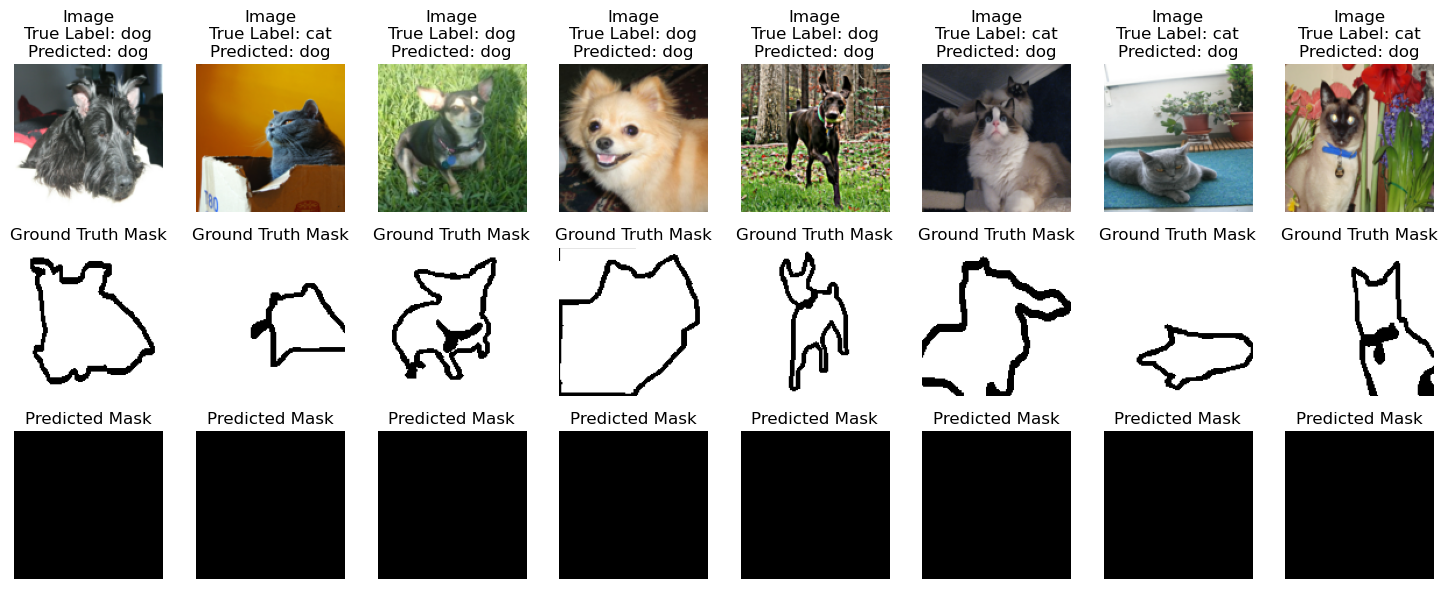

Epoch 2/100 - Seg Loss: 0.3480 | Cls Loss: 0.6313
Epoch 3/100 - Seg Loss: 0.3437 | Cls Loss: 0.6281
Epoch 4/100 - Seg Loss: 0.3398 | Cls Loss: 0.6252
Epoch 5/100 - Seg Loss: 0.3369 | Cls Loss: 0.6158
Epoch 6/100 - Seg Loss: 0.3343 | Cls Loss: 0.6057
Epoch 7/100 - Seg Loss: 0.3320 | Cls Loss: 0.5926
Epoch 8/100 - Seg Loss: 0.3298 | Cls Loss: 0.5868
Epoch 9/100 - Seg Loss: 0.3268 | Cls Loss: 0.5766
Epoch 10/100 - Seg Loss: 0.3243 | Cls Loss: 0.5719
Epoch 11/100 - Seg Loss: 0.3227 | Cls Loss: 0.5677


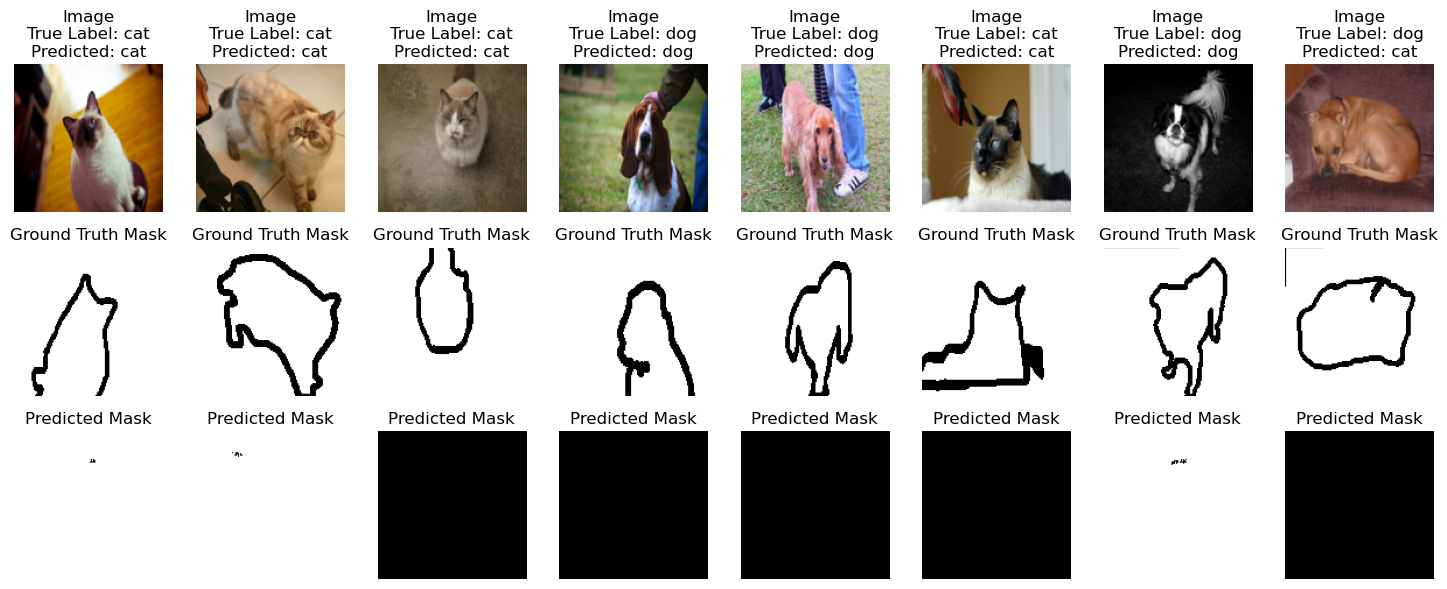

Epoch 12/100 - Seg Loss: 0.3201 | Cls Loss: 0.5601
Epoch 13/100 - Seg Loss: 0.3179 | Cls Loss: 0.5538
Epoch 14/100 - Seg Loss: 0.3156 | Cls Loss: 0.5479
Epoch 15/100 - Seg Loss: 0.3145 | Cls Loss: 0.5459
Epoch 16/100 - Seg Loss: 0.3124 | Cls Loss: 0.5367
Epoch 17/100 - Seg Loss: 0.3104 | Cls Loss: 0.5325
Epoch 18/100 - Seg Loss: 0.3086 | Cls Loss: 0.5247
Epoch 19/100 - Seg Loss: 0.3066 | Cls Loss: 0.5218
Epoch 20/100 - Seg Loss: 0.3038 | Cls Loss: 0.5116
Epoch 21/100 - Seg Loss: 0.3036 | Cls Loss: 0.5086


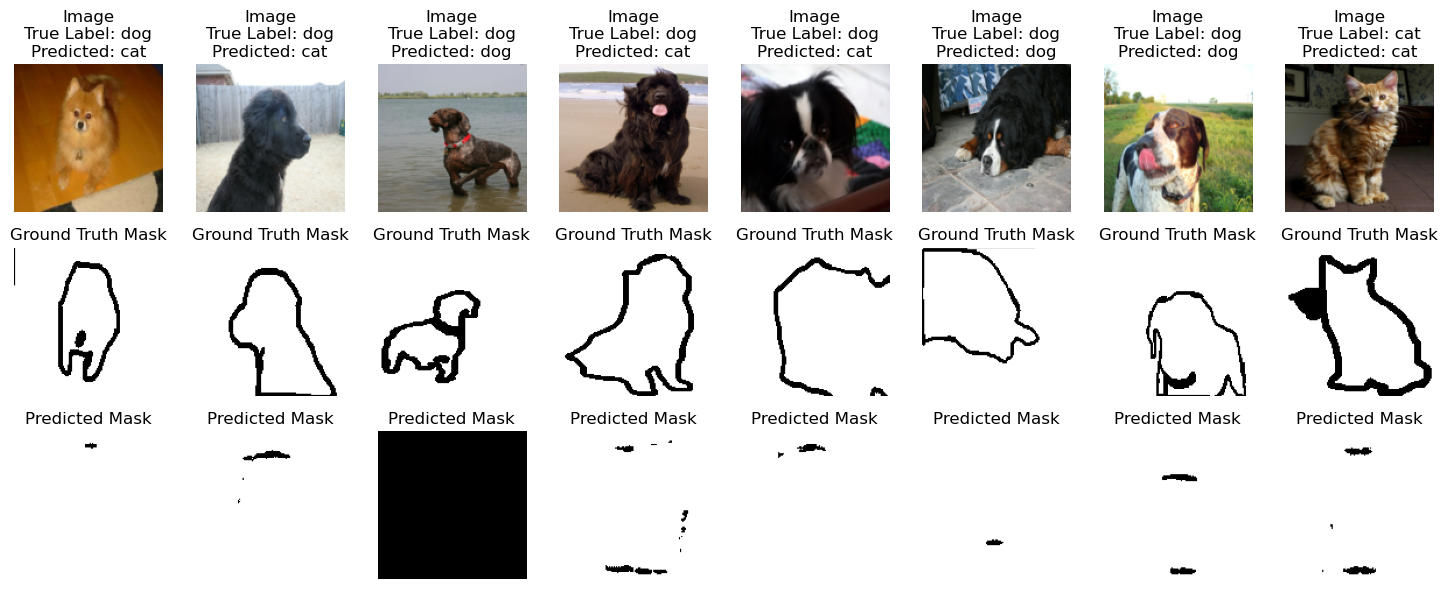

Epoch 22/100 - Seg Loss: 0.3017 | Cls Loss: 0.5047
Epoch 23/100 - Seg Loss: 0.2988 | Cls Loss: 0.5002
Epoch 24/100 - Seg Loss: 0.2967 | Cls Loss: 0.4956
Epoch 25/100 - Seg Loss: 0.2946 | Cls Loss: 0.4919
Epoch 26/100 - Seg Loss: 0.2923 | Cls Loss: 0.4901
Epoch 27/100 - Seg Loss: 0.2911 | Cls Loss: 0.4831
Epoch 28/100 - Seg Loss: 0.2873 | Cls Loss: 0.4812
Epoch 29/100 - Seg Loss: 0.2855 | Cls Loss: 0.4786
Epoch 30/100 - Seg Loss: 0.2831 | Cls Loss: 0.4776
Epoch 31/100 - Seg Loss: 0.2805 | Cls Loss: 0.4726


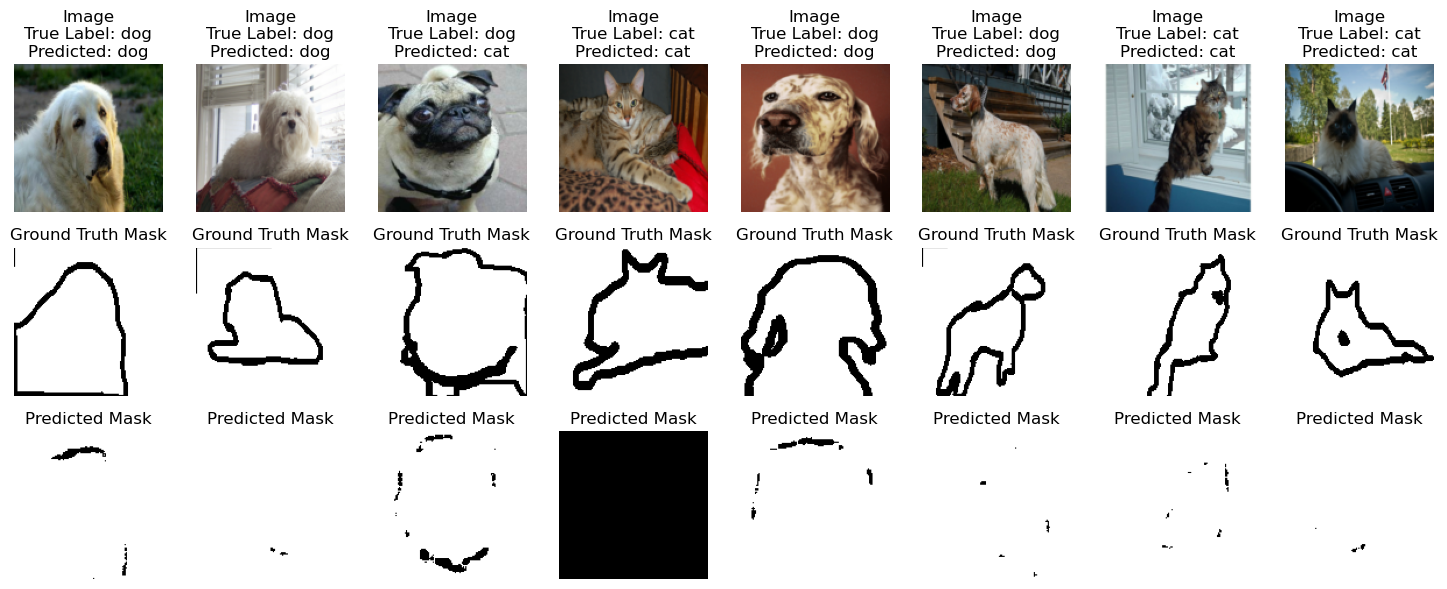

Epoch 32/100 - Seg Loss: 0.2781 | Cls Loss: 0.4678
Epoch 33/100 - Seg Loss: 0.2757 | Cls Loss: 0.4707
Epoch 34/100 - Seg Loss: 0.2728 | Cls Loss: 0.4644
Epoch 35/100 - Seg Loss: 0.2700 | Cls Loss: 0.4641
Epoch 36/100 - Seg Loss: 0.2669 | Cls Loss: 0.4618
Epoch 37/100 - Seg Loss: 0.2651 | Cls Loss: 0.4593
Epoch 38/100 - Seg Loss: 0.2622 | Cls Loss: 0.4594
Epoch 39/100 - Seg Loss: 0.2610 | Cls Loss: 0.4596
Epoch 40/100 - Seg Loss: 0.2577 | Cls Loss: 0.4598
Epoch 41/100 - Seg Loss: 0.2549 | Cls Loss: 0.4599


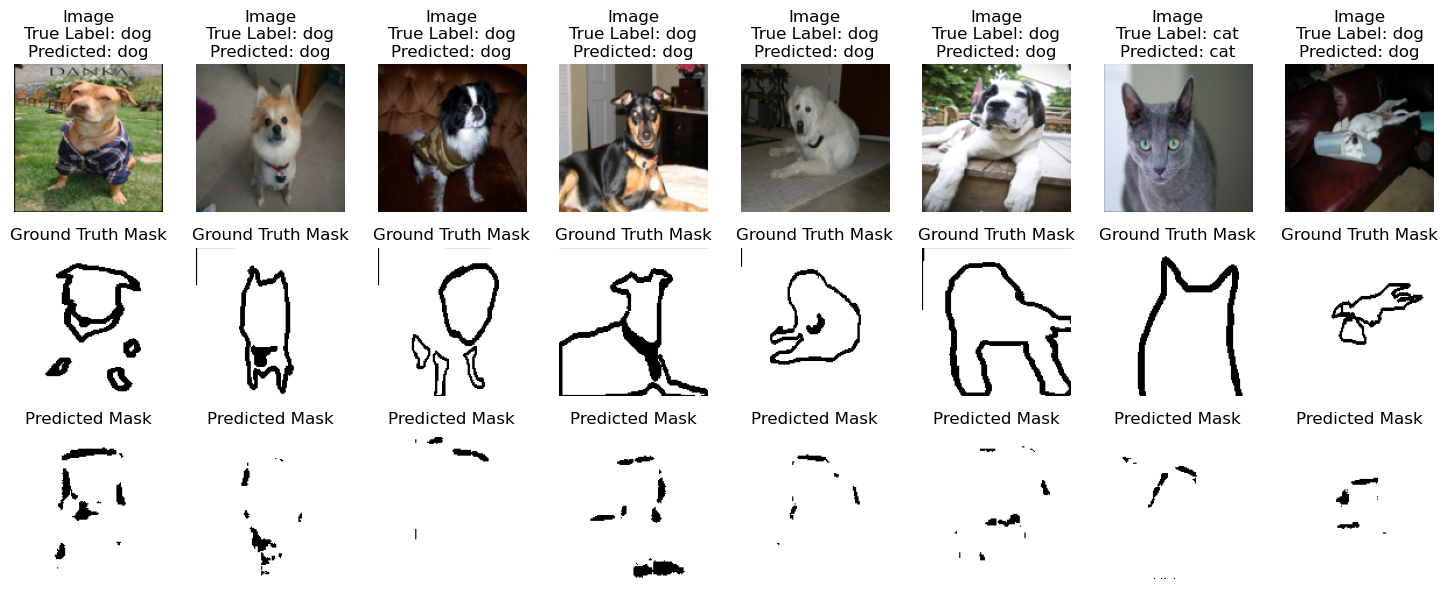

Epoch 42/100 - Seg Loss: 0.2514 | Cls Loss: 0.4553
Epoch 43/100 - Seg Loss: 0.2494 | Cls Loss: 0.4546
Epoch 44/100 - Seg Loss: 0.2460 | Cls Loss: 0.4546
Epoch 45/100 - Seg Loss: 0.2445 | Cls Loss: 0.4533
Epoch 46/100 - Seg Loss: 0.2413 | Cls Loss: 0.4521
Epoch 47/100 - Seg Loss: 0.2394 | Cls Loss: 0.4520
Epoch 48/100 - Seg Loss: 0.2364 | Cls Loss: 0.4506
Epoch 49/100 - Seg Loss: 0.2356 | Cls Loss: 0.4509
Epoch 50/100 - Seg Loss: 0.2342 | Cls Loss: 0.4511
Epoch 51/100 - Seg Loss: 0.2310 | Cls Loss: 0.4499


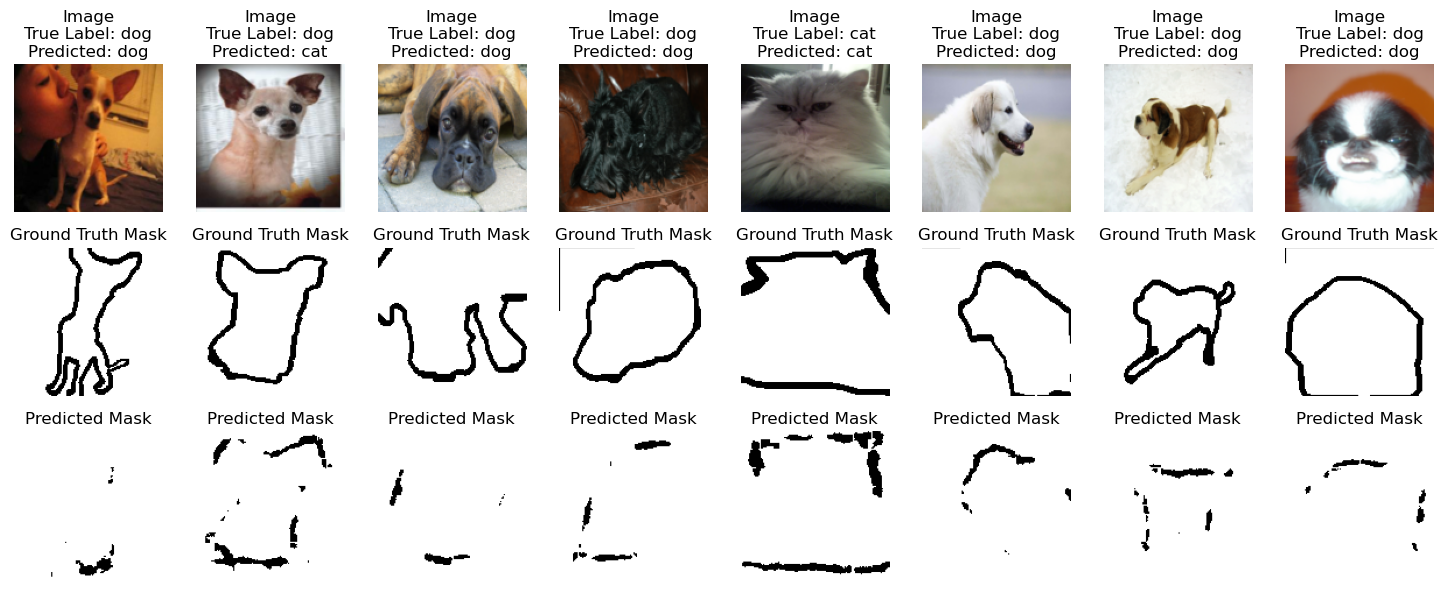

Epoch 52/100 - Seg Loss: 0.2284 | Cls Loss: 0.4503
Epoch 53/100 - Seg Loss: 0.2274 | Cls Loss: 0.4501
Epoch 54/100 - Seg Loss: 0.2252 | Cls Loss: 0.4508
Epoch 55/100 - Seg Loss: 0.2234 | Cls Loss: 0.4488
Epoch 56/100 - Seg Loss: 0.2198 | Cls Loss: 0.4475
Epoch 57/100 - Seg Loss: 0.2191 | Cls Loss: 0.4472
Epoch 58/100 - Seg Loss: 0.2175 | Cls Loss: 0.4476
Epoch 59/100 - Seg Loss: 0.2176 | Cls Loss: 0.4494
Epoch 60/100 - Seg Loss: 0.2139 | Cls Loss: 0.4460
Epoch 61/100 - Seg Loss: 0.2117 | Cls Loss: 0.4475


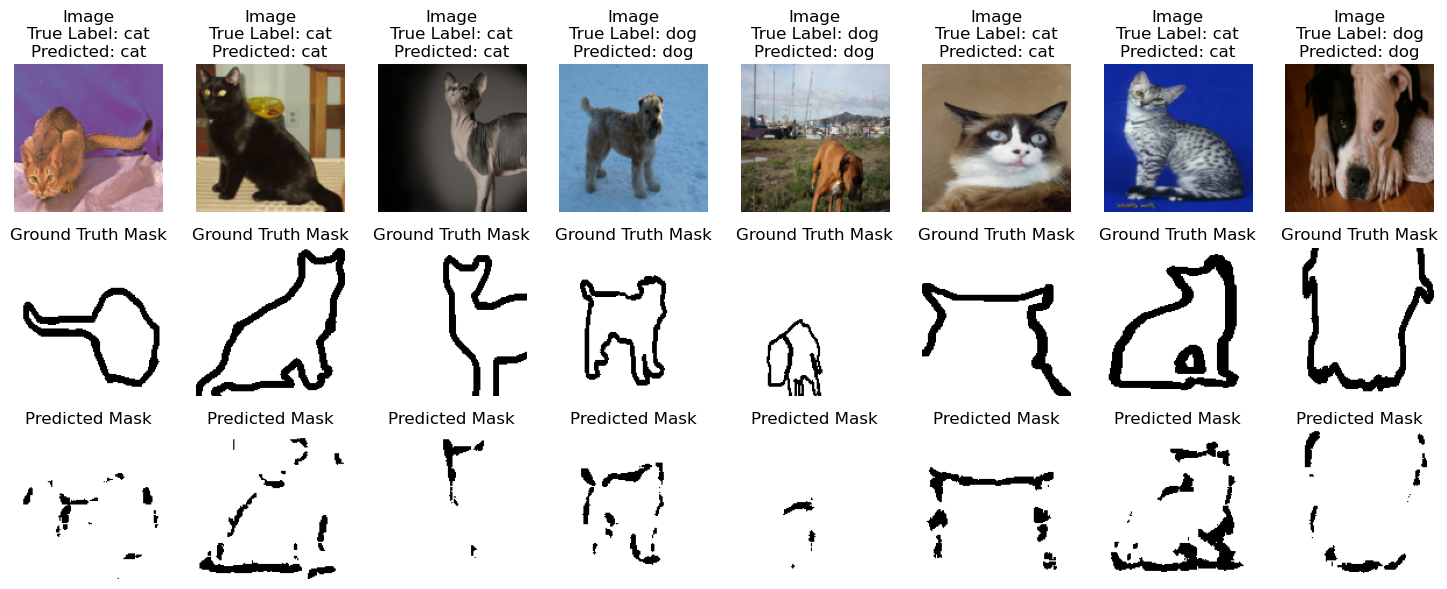

Epoch 62/100 - Seg Loss: 0.2114 | Cls Loss: 0.4486
Epoch 63/100 - Seg Loss: 0.2098 | Cls Loss: 0.4482
Epoch 64/100 - Seg Loss: 0.2072 | Cls Loss: 0.4467
Epoch 65/100 - Seg Loss: 0.2102 | Cls Loss: 0.4513
Epoch 66/100 - Seg Loss: 0.2057 | Cls Loss: 0.4470
Epoch 67/100 - Seg Loss: 0.2048 | Cls Loss: 0.4478
Epoch 68/100 - Seg Loss: 0.2026 | Cls Loss: 0.4463
Epoch 69/100 - Seg Loss: 0.2013 | Cls Loss: 0.4474
Epoch 70/100 - Seg Loss: 0.2012 | Cls Loss: 0.4468
Epoch 71/100 - Seg Loss: 0.1994 | Cls Loss: 0.4465


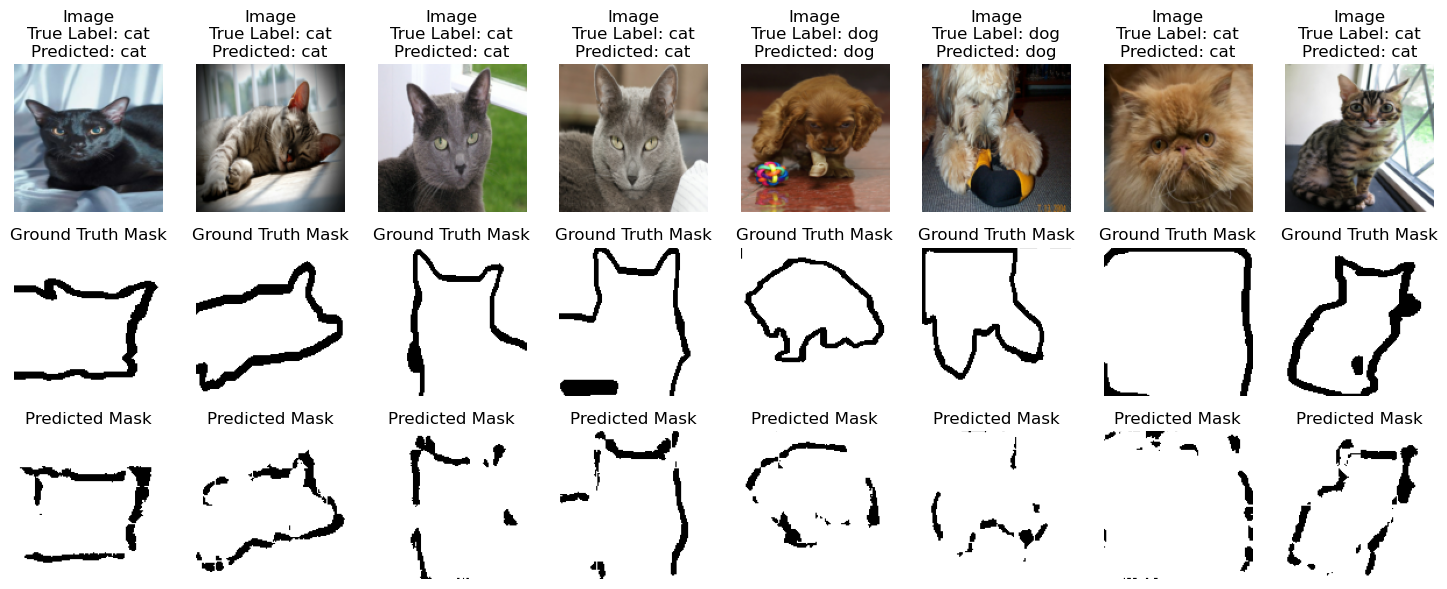

Epoch 72/100 - Seg Loss: 0.1982 | Cls Loss: 0.4471
Epoch 73/100 - Seg Loss: 0.1998 | Cls Loss: 0.4493
Epoch 74/100 - Seg Loss: 0.1960 | Cls Loss: 0.4448
Epoch 75/100 - Seg Loss: 0.1959 | Cls Loss: 0.4467
Epoch 76/100 - Seg Loss: 0.1940 | Cls Loss: 0.4463
Epoch 77/100 - Seg Loss: 0.1920 | Cls Loss: 0.4456
Epoch 78/100 - Seg Loss: 0.1926 | Cls Loss: 0.4479
Epoch 79/100 - Seg Loss: 0.1916 | Cls Loss: 0.4468
Epoch 80/100 - Seg Loss: 0.1899 | Cls Loss: 0.4453
Epoch 81/100 - Seg Loss: 0.1887 | Cls Loss: 0.4444


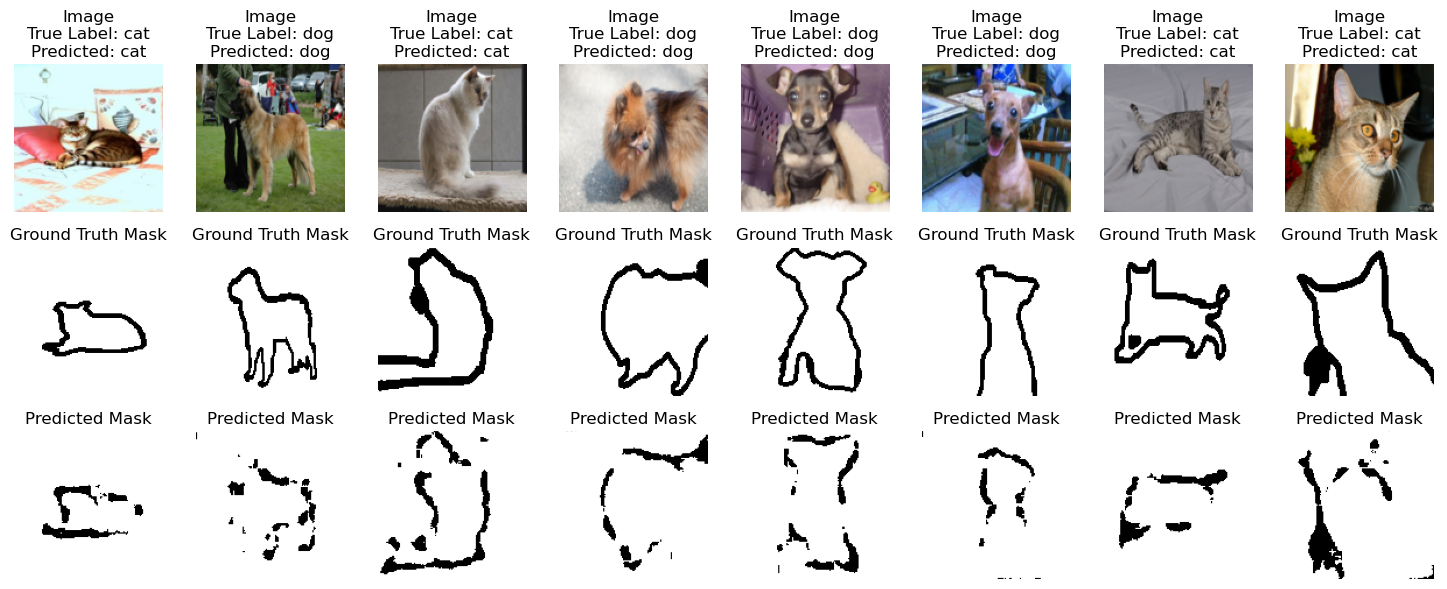

Epoch 82/100 - Seg Loss: 0.1915 | Cls Loss: 0.4480
Epoch 83/100 - Seg Loss: 0.1868 | Cls Loss: 0.4447
Epoch 84/100 - Seg Loss: 0.1857 | Cls Loss: 0.4466
Epoch 85/100 - Seg Loss: 0.1876 | Cls Loss: 0.4462
Epoch 86/100 - Seg Loss: 0.1842 | Cls Loss: 0.4456
Epoch 87/100 - Seg Loss: 0.1853 | Cls Loss: 0.4471
Epoch 88/100 - Seg Loss: 0.1854 | Cls Loss: 0.4475
Epoch 89/100 - Seg Loss: 0.1831 | Cls Loss: 0.4451
Epoch 90/100 - Seg Loss: 0.1820 | Cls Loss: 0.4457
Epoch 91/100 - Seg Loss: 0.1800 | Cls Loss: 0.4449


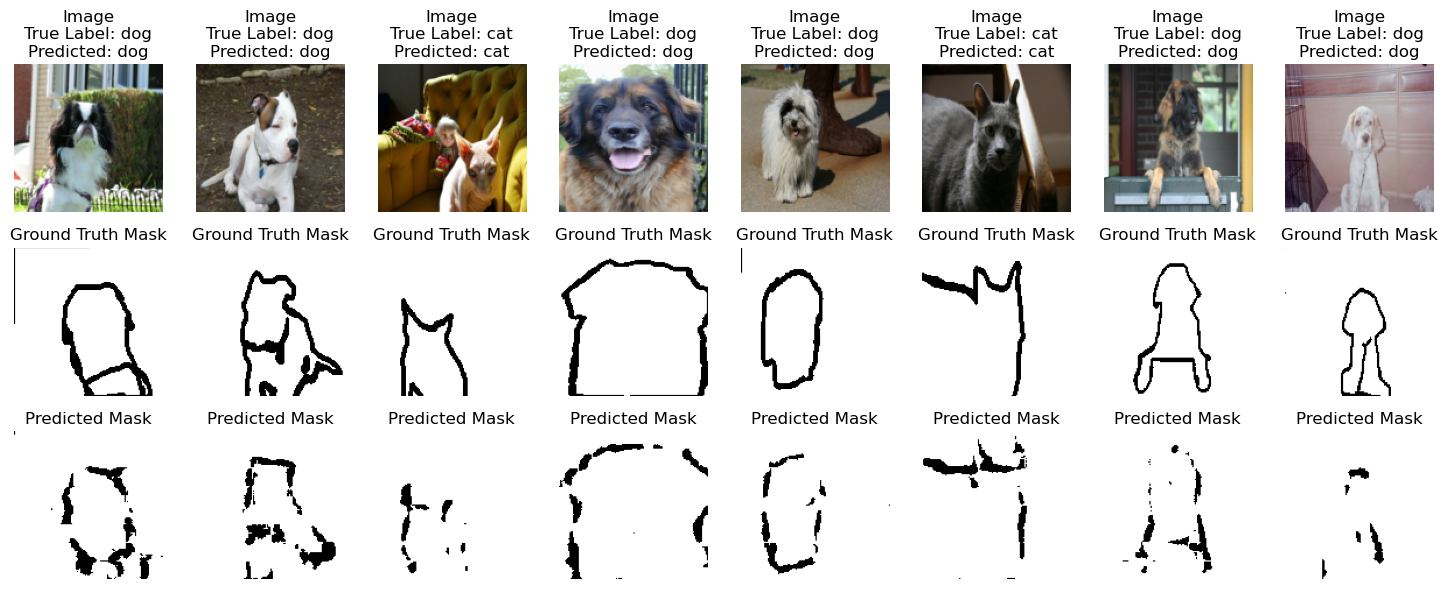

Epoch 92/100 - Seg Loss: 0.1798 | Cls Loss: 0.4448
Epoch 93/100 - Seg Loss: 0.1843 | Cls Loss: 0.4508
Epoch 94/100 - Seg Loss: 0.1830 | Cls Loss: 0.4484
Epoch 95/100 - Seg Loss: 0.1778 | Cls Loss: 0.4448
Epoch 96/100 - Seg Loss: 0.1768 | Cls Loss: 0.4457
Epoch 97/100 - Seg Loss: 0.1797 | Cls Loss: 0.4471
Epoch 98/100 - Seg Loss: 0.1822 | Cls Loss: 0.4518
Epoch 99/100 - Seg Loss: 0.1826 | Cls Loss: 0.4487
Epoch 100/100 - Seg Loss: 0.1754 | Cls Loss: 0.4471


In [109]:
model = SegClassCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

evaluate_model(model, optimizer, dataloader, device)

I experimented with different weights for the segmentation and classification loss since binary classification was learning faster than segmentation. I put more weight on segmentation so that by the end of the 100 epochs, the loss would be comparable to the CNN model used only for segmentation. In the end this combined model was able to predict both classification and segmentation well. 